In [1]:
import os
import glob
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from scipy.signal import cwt, ricker
from sklearn.ensemble import RandomForestRegressor
import scipy as sc
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from fracdiff import fdiff
from tqdm.notebook import tqdm
from IPython.display import display
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

In [2]:
data_path = "X:\\Data\\optiverRV\\"

In [3]:
train, test = pd.read_csv(data_path+"train.csv"), pd.read_csv(data_path+"test.csv")
book_train, book_test = lambda stock_id: pd.read_parquet(data_path+"book_train.parquet\\stock_id="+str(stock_id)), lambda stock_id: pd.read_parquet(data_path+"book_test.parquet\\stock_id="+str(stock_id))
trade_train, trade_test = lambda stock_id: pd.read_parquet(data_path+"trade_train.parquet\\stock_id="+str(stock_id)), lambda stock_id: pd.read_parquet(data_path+"trade_test.parquet\\stock_id="+str(stock_id))
stock_ids = train["stock_id"].unique()
train['row_id'] = train['stock_id'].apply(str)+"-"+train['time_id'].apply(str)
print("RV Labels")
display(train.head())
print("Size:",len(train))
print("Order book")
display(book_train(0).head())
print("Size:",len(book_train(0)))
print("Trade data")
display(trade_train(0).head())
print("Size:",len(trade_train(0)))

RV Labels


,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62


Size: 428932
Order book


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


Size: 917553
Trade data


,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


Size: 123443


<AxesSubplot:xlabel='stock_id'>

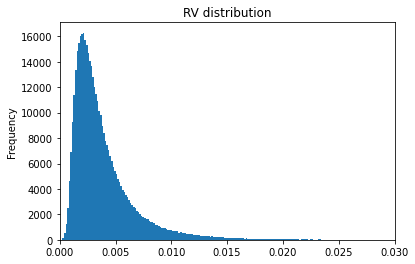

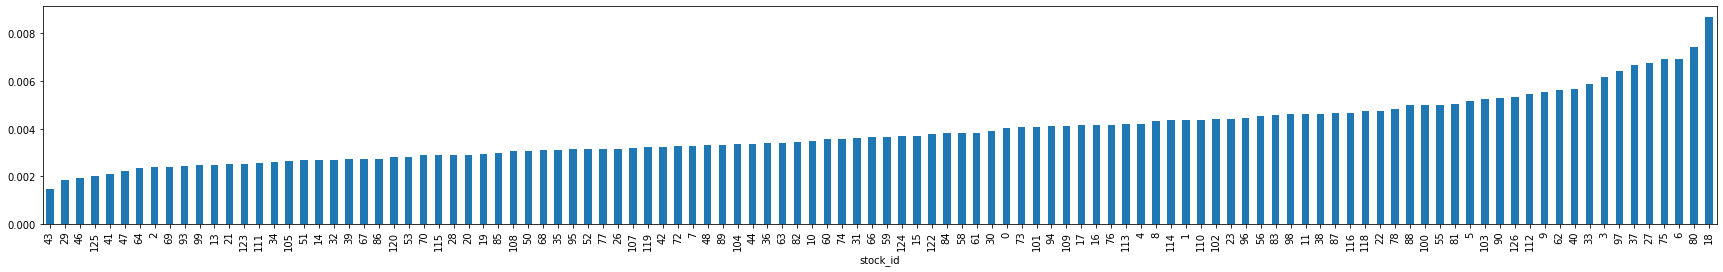

In [4]:
plt.figure()
train["target"].plot.hist(bins=500, title="RV distribution", xlim=(0, 0.03))

target_mean = train.groupby('stock_id')['target'].mean()
target_mean.columns = ["mean"]
target_mean.sort_values( ascending=True, inplace=True)
plt.figure(figsize=(30,4))
target_mean.plot.bar()

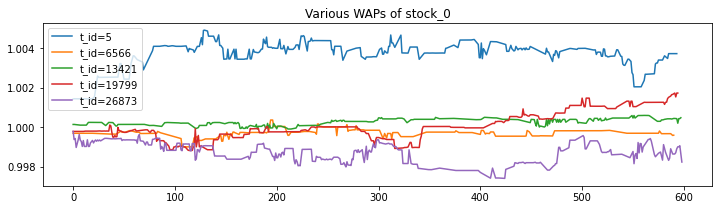

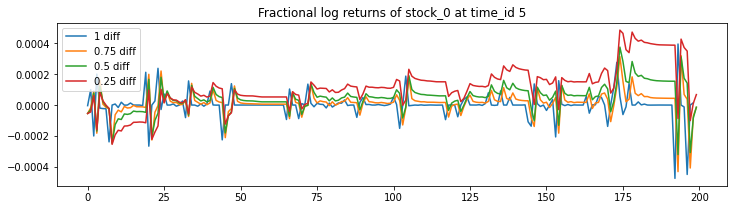

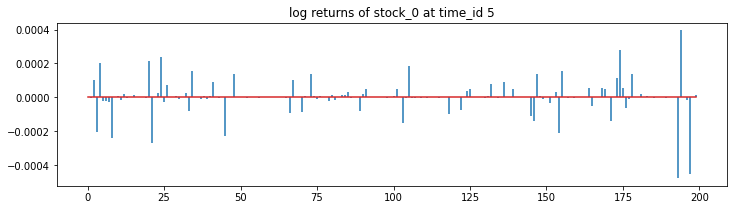

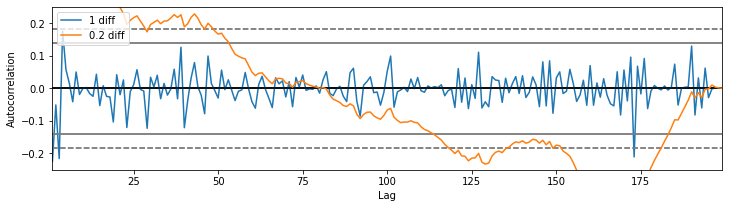

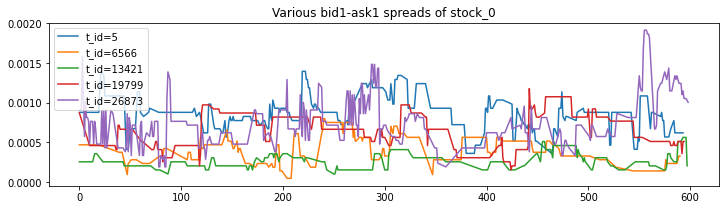

In [5]:
wap_n = lambda book, idx: (book[f'bid_price{idx}']*book[f'ask_size{idx}']+book[f'ask_price{idx}']*book[f'bid_size{idx}'])/(book[f'bid_size{idx}']+book[f'ask_size{idx}'])
lagged_logret_sq = lambda df, wap, n: np.log(df[f'wap{wap}'] / df.groupby('time_id')[f'wap{wap}'].shift(n))

book_example = book_train(0)
print()
plt.figure(figsize=(12, 3))
for t_id in book_example["time_id"].unique()[0:-1:800]:
    plt.plot(book_example["seconds_in_bucket"].loc[book_example["time_id"]==t_id], wap_n(book_example.loc[book_example["time_id"]==t_id], 1), label=f"t_id={t_id}");
plt.legend(loc="upper left")
plt.title("Various WAPs of stock_0")

wap_example = wap_n(book_example.loc[book_example["time_id"]==11], 1)
log_ret_example = np.log(wap_example).diff()
log_frac_ret_example = lambda gamma: fdiff(np.log(wap_example), gamma)
plt.figure(figsize=(12, 3))
for gamma in [1, 0.75, 0.5, 0.25]:
    plt.plot(log_frac_ret_example(gamma), label=f"{gamma} diff");
plt.legend(loc="upper left")
plt.title("Fractional log returns of stock_0 at time_id 5");
plt.figure(figsize=(12, 3))
plt.stem(log_ret_example, markerfmt=" ");
plt.title("log returns of stock_0 at time_id 5");

plt.figure(figsize=(12, 3))
for gamma in [1, 0.2]:
    pd.plotting.autocorrelation_plot(log_frac_ret_example(gamma)[1:], label=f"{gamma} diff")
plt.ylim(-0.25, 0.25)
plt.legend(loc="upper left")

bid_ask_spread = lambda t_id: abs(book_example['bid_price1'].loc[book_example["time_id"]==t_id] - book_example['ask_price1'].loc[book_example["time_id"]==t_id])
plt.figure(figsize=(12, 3))
for t_id in book_example["time_id"].unique()[0:-1:800]:
    plt.plot(book_example["seconds_in_bucket"].loc[book_example["time_id"]==t_id], bid_ask_spread(t_id), label=f"t_id={t_id}");
plt.legend(loc="upper left")
plt.title("Various bid1-ask1 spreads of stock_0");

(200,)

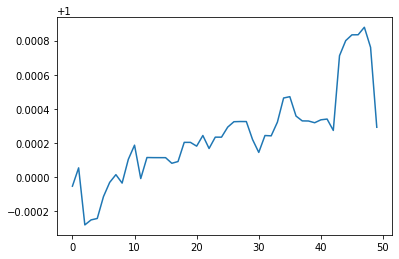

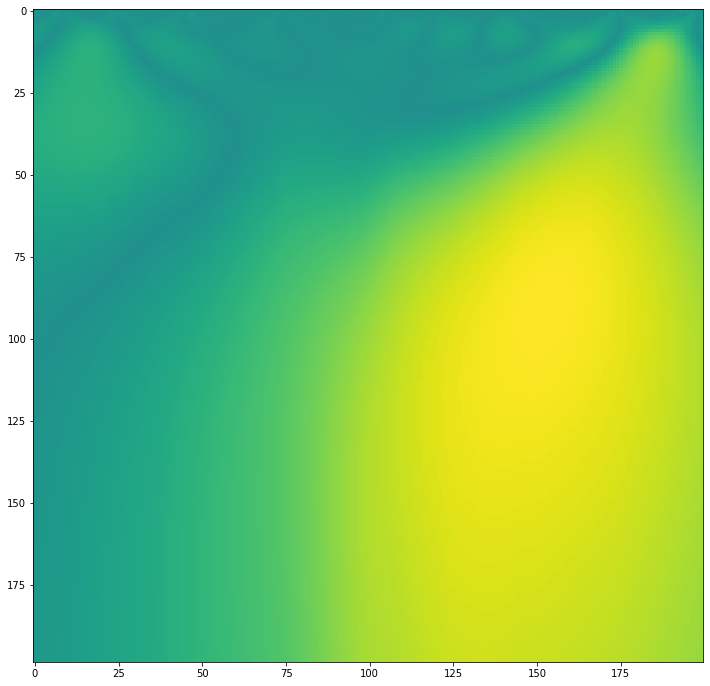

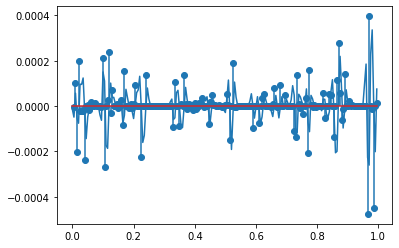

In [16]:
from scipy import signal
from scipy.signal import cspline1d, cspline1d_eval
filtered = cspline1d_eval(cspline1d(wap_example.values), np.linspace(0, len(wap_example)))
t = np.linspace(0, 1, len(wap_example), endpoint=False)
plt.figure()
plt.plot(filtered)
cwt_ = cwt(np.log(wap_example), ricker, np.arange(1, 200, 1))
plt.figure(figsize=(12,12))
plt.imshow(np.abs(cwt_), aspect='auto', vmax=abs(cwt_).max(), vmin=-abs(cwt_).max())
plt.figure()
plt.plot(t, cwt_[0, :])
# plt.plot(t, cwt_[1, :])
# plt.plot(t, cwt_[2, :])
# plt.plot(t, cwt_[3, :])
plt.stem(t, np.log(wap_example).diff())
cwt_.T[:, 0].shape

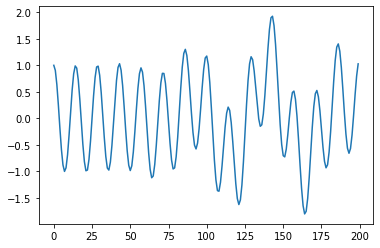

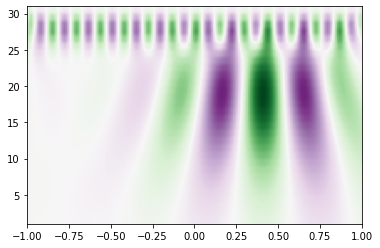

In [87]:
from scipy import signal

import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 200, endpoint=False)

sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
plt.figure()
plt.plot(sig)
plt.figure()
widths = np.arange(1, 31)

cwtmatr = signal.cwt(sig, signal.ricker, widths)

plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',

           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.show()

### Feature extraction from buckets

In [11]:
def max_move(buckets):
    return buckets.max()-buckets.min()
def num_outliers(buckets):
    q1, q3 = buckets.quantile(0.25), buckets.quantile(0.75)
    iqr = q3-q1
    return ((buckets<(q1 - 1.5*iqr))|(buckets>(q3+1.5*iqr))).sum()
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

extraction_function_list1 = [np.sum, np.mean, np.std, sc.stats.kurtosis]
extraction_function_list2 = [np.sum, np.mean, np.std]
extraction_function_list3 = [np.sum, np.mean, np.std, sc.stats.kurtosis, num_outliers, max_move]

def bucket_characterization(bucket):
    mean = bucket.mean
    std = bucket.std()
    kurtosis = bucket.kurtosis()
    tot = bucket.sum()
    max_move = bucket.max()-bucket.min()
    q1, q3 = bucket.quantile(0.25), bucket.quantile(0.75)
    iqr = q3-q1
    num_outliers = ((bucket<(q1 - 1.5*iqr))|(bucket>(q3+1.5*iqr))).sum()
    median = bucket.median()
    print(max_move)
#display(book_example.groupby("time_id").apply(num_outliers))
#bucket_characterization(book_example.loc[book_example["time_id"]==5])

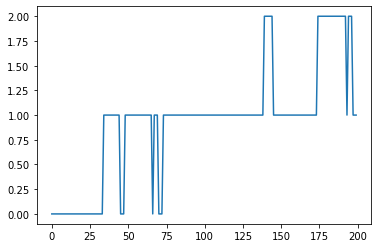

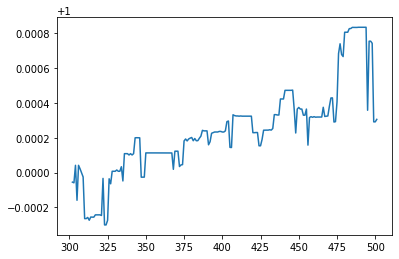

In [12]:
plt.plot(KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform').fit(wap_example.values.reshape(-1, 1)).transform(wap_example.values.reshape(-1, 1)))
plt.figure()
plt.plot(wap_example)

In [13]:
import functools

log_return = lambda series : np.log(series).diff()
fractional_log_return = lambda series, gamma: fdiff(np.log(series), gamma)
multi_scale_1 = lambda series: cwt(np.log(series), ricker, [1]).T[:,0]
multi_scale_2 = lambda series: cwt(np.log(series), ricker, [5]).T[:,0]
multi_scale_3 = lambda series: cwt(np.log(series), ricker, [15]).T[:,0]
vol_rank = lambda series: KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit(series.values.reshape(-1, 1)).transform(series.values.reshape(-1, 1))

def preproc_book(book_func, id):
    # based on https://www.kaggle.com/mayangrui/lgbm-ffnn

    df_book = book_func(id)
    # book
    for wap_idx in [1, 2]:
        df_book[f'wap{wap_idx}'] = wap_n(df_book, wap_idx)
        df_book[f"log_return{wap_idx}"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].apply(log_return)
        # cwt_ = cwt(np.log(wap_example), ricker, np.arange(1,20, 3))

            # print(df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(functools.partial(cwt, wavelet=ricker, widths=[scale] )).T[:,0])
        df_book[f"scale_1"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(multi_scale_1)
        df_book[f"scale_2"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(multi_scale_2)
        df_book[f"scale_3"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(multi_scale_3)
        # df_book[f"dwt{wap_idx}"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].apply(log_return)
        df_book[f"frac_diff{wap_idx}_05"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(functools.partial(fractional_log_return, gamma=0.5 ))
        df_book[f"frac_diff{wap_idx}_02"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(functools.partial(fractional_log_return, gamma=0.2 ))
        df_book[f"frac_diff{wap_idx}_08"] = df_book.groupby(['time_id'])[f'wap{wap_idx}'].transform(functools.partial(fractional_log_return, gamma=0.8 ))
        df_book[f'price_spread{wap_idx}'] = (df_book[f'ask_price{wap_idx}'] - df_book[f'bid_price{wap_idx}']) / ((df_book[f'ask_price{wap_idx}'] + df_book[f'bid_price{wap_idx}']) / 2)
    df_book['wap_spread'] = abs(df_book['wap1'] - df_book['wap2'])
    df_book['bid_spread'] = df_book["bid_price1"]-df_book["bid_price2"]
    df_book['ask_spread'] = df_book["ask_price1"]-df_book["ask_price2"]
    df_book['bid_ask_spread'] = abs(df_book['bid_spread'] - df_book['ask_spread'])
    df_book['total_volume'] = (df_book['ask_size1'] + df_book['ask_size2']) + (df_book['bid_size1'] + df_book['bid_size2'])
    df_book['volume_imbalance'] = abs((df_book['ask_size1'] + df_book['ask_size2']) - (df_book['bid_size1'] + df_book['bid_size2']))
    df_book = df_book[~df_book['log_return1'].isnull()]
    # display(df_book.head(30))
    create_feature_dict = {
        'wap1': extraction_function_list2,
        'wap2': extraction_function_list2,
        'log_return1': extraction_function_list3+[realized_volatility],
        'log_return2': extraction_function_list3+[realized_volatility],
        'frac_diff1_05': extraction_function_list3+[realized_volatility],
        'frac_diff2_05': extraction_function_list3+[realized_volatility],
        'frac_diff1_02': extraction_function_list3+[realized_volatility],
        'frac_diff2_02': extraction_function_list3+[realized_volatility],
        'frac_diff1_08': extraction_function_list3+[realized_volatility],
        'frac_diff2_08': extraction_function_list3+[realized_volatility],
        'scale_1': [realized_volatility],
        'scale_2': [realized_volatility],
        'scale_3': [realized_volatility],
        'wap_spread': extraction_function_list2,
        'price_spread1':extraction_function_list2,
        'price_spread2':extraction_function_list2,
        'bid_spread':extraction_function_list2,
        'ask_spread':extraction_function_list2,
        'total_volume':extraction_function_list2,
        'volume_imbalance':extraction_function_list2,
        "bid_ask_spread":extraction_function_list2,
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility]
    }
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df_book[df_book['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature

    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    # display(df_feature_500)
    # df_feature_500['vol_rank_500'] = vol_rank(df_feature_500['log_return1_realized_volatility_500'])
    # df_feature_400['vol_rank_400'] = vol_rank(df_feature_400['log_return1_realized_volatility_400'])
    # df_feature_300['vol_rank_300'] = vol_rank(df_feature_300['log_return1_realized_volatility_300'])
    # df_feature_200['vol_rank_200'] = vol_rank(df_feature_200['log_return1_realized_volatility_200'])
    # df_feature_500['vol_rank_100'] = vol_rank(df_feature_100['log_return1_realized_volatility_100'])
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{id}-{x}')
    return df_feature

book_features = preproc_book(book_train, 0)
display(book_features.head())

,time_id_,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_mean,log_return1_std,log_return1_kurtosis,log_return1_num_outliers,log_return1_max_move,log_return1_realized_volatility,log_return2_sum,log_return2_mean,log_return2_std,log_return2_kurtosis,log_return2_num_outliers,log_return2_max_move,log_return2_realized_volatility,frac_diff1_05_sum,frac_diff1_05_mean,frac_diff1_05_std,frac_diff1_05_kurtosis,frac_diff1_05_num_outliers,frac_diff1_05_max_move,frac_diff1_05_realized_volatility,frac_diff2_05_sum,frac_diff2_05_mean,frac_diff2_05_std,frac_diff2_05_kurtosis,frac_diff2_05_num_outliers,frac_diff2_05_max_move,frac_diff2_05_realized_volatility,frac_diff1_02_sum,frac_diff1_02_mean,frac_diff1_02_std,frac_diff1_02_kurtosis,frac_diff1_02_num_outliers,frac_diff1_02_max_move,frac_diff1_02_realized_volatility,frac_diff2_02_sum,frac_diff2_02_mean,frac_diff2_02_std,frac_diff2_02_kurtosis,frac_diff2_02_num_outliers,frac_diff2_02_max_move,frac_diff2_02_realized_volatility,frac_diff1_08_sum,frac_diff1_08_mean,frac_diff1_08_std,frac_diff1_08_kurtosis,frac_diff1_08_num_outliers,frac_diff1_08_max_move,frac_diff1_08_realized_volatility,frac_diff2_08_sum,frac_diff2_08_mean,frac_diff2_08_std,frac_diff2_08_kurtosis,frac_diff2_08_num_outliers,frac_diff2_08_max_move,frac_diff2_08_realized_volatility,scale_1_realized_volatility,scale_2_realized_volatility,scale_3_realized_volatility,wap_spread_sum,wap_spread_mean,wap_spread_std,price_spread1_sum,price_spread1_mean,price_spread1_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,row_id
0,5,302.123627,1.003733,0.000682,302.104149,1.003668,0.000771,0.002292,7.613599e-06,0.000260,2.386964,107,0.001945,0.004499,0.002325,0.000008,0.000404,4.444262,109,0.003939,0.006999,0.213018,0.000708,0.000259,0.873921,18,0.001736,0.013072,0.209140,0.000695,0.000380,2.057131,11,0.003244,0.013738,0.619212,0.002057,0.000406,2.122686,25,0.002281,0.036376,0.608308,0.002021,0.000505,0.336551,16,0.002622,0.036137,0.045345,0.000151,0.000248,2.089477,65,0.001763,0.005034,0.044510,0.000148,0.000383,4.489016,62,0.003771,0.007112,0.006305,0.019835,0.034659,0.117007,0.000389,0.000295,0.256378,0.000852,0.000212,0.354470,0.001178,0.000213,0.052954,0.000176,0.000163,-0.045505,-0.000151,0.000126,97365,323.471761,138.330510,40417,134.275748,106.898770,0.098460,0.000327,0.000222,0.001459,0.003018,0.002300,0.004589,0.002953,0.004863,0.003402,0.005802,0.004041,0.006566,0-5
1,11,199.047823,1.000240,0.000262,199.041366,1.000208,0.000271,0.000360,1.810239e-06,0.000086,11.368161,65,0.000872,0.001204,0.000801,0.000004,0.000176,3.858067,76,0.001319,0.002476,0.009557,0.000048,0.000092,3.187874,18,0.000698,0.001457,0.008832,0.000044,0.000162,2.657262,14,0.001278,0.002364,0.026773,0.000135,0.000158,0.574530,38,0.000783,0.002928,0.023516,0.000118,0.000198,0.855991,6,0.001310,0.003248,0.002292,0.000012,0.000082,10.351818,41,0.000777,0.001166,0.002536,0.000013,0.000165,3.751163,45,0.001298,0.002333,0.002069,0.006276,0.011011,0.042171,0.000212,0.000155,0.078133,0.000393,0.000156,0.133228,0.000669,0.000200,0.028308,0.000142,0.000149,-0.026800,-0.000135,0.000065,81935,411.733668,172.651206,28315,142.286432,102.342480,0.055108,0.000277,0.000158,0.000857,0.001435,0.000934,0.001907,0.000981,0.002009,0.001014,0.002105,0.001140,0.002432,0-11
2,16,186.914174,0.999541,0.000867,186.940463,0.999682,0.000864

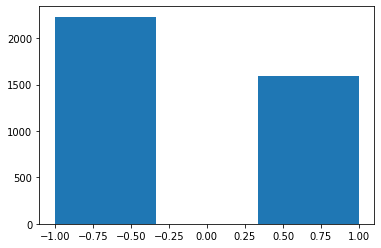

In [20]:
directions_0 = np.where(book_features['log_return1_realized_volatility'].values<train['target'].loc[train['stock_id']==0].values, 1, -1)
plt.hist(directions_0, bins=3);

In [205]:
def count_unique(series):
    return len(series.unique())
def preproc_trade(trade_func, id, lags=(2, 5, 10), coarse_grain=False):
    # based on https://www.kaggle.com/mayangrui/lgbm-ffnn
    df_trade = trade_func(id)
    df_trade['log_return'] = df_trade.groupby('time_id')['price'].apply(log_return)
    df_trade['trade_volume'] = df_trade['price']*df_trade['size']
    if coarse_grain: #Not fully implemented
        for i, lag in enumerate(lags):
            df_trade[f'OBV_{i}'] = np.where(df_trade['price'] > df_trade['price'].shift(lag), df_trade['trade_volume'],
                     np.where(df_trade['price'] < df_trade['price'].shift(lag), -df_trade['trade_volume'], 0)).cumsum()
    else:
        lag = 1
        # df_trade[f'SMA_{lag-1}'] = df_trade['price'].rolling(window=lag).mean()
        df_trade[f'OBV_{lag-1}'] = np.where(df_trade['price'] > df_trade['price'].shift(lag), df_trade['trade_volume'],
                                          np.where(df_trade['price'] < df_trade['price'].shift(lag), -df_trade['trade_volume'], 0)).cumsum()
        df_trade[f'OBV_{lag-1}'] = df_trade[f'OBV_{lag-1}']

    df_trade.dropna(inplace=True)

    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'trade_volume':[np.sum,np.max,np.min],
        'OBV_0':[max_move, np.max, np.min, np.mean]
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'trade_volume':[np.sum],
        'OBV_0':[max_move]
    }
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df_trade[df_trade['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{id}-{x}')
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    return df_feature
trade_features = preproc_trade(trade_train, 1)
trade_features.head()

,time_id_,log_return_realized_volatility,seconds_in_bucket_count_unique,size_sum,size_amax,size_amin,order_count_sum,order_count_amax,trade_volume_sum,trade_volume_amax,trade_volume_amin,OBV_0_max_move,OBV_0_amax,OBV_0_amin,OBV_0_mean,row_id
0,5,0.003087,93,9455,1869,1,301,21,9489.608073,1876.184924,1.002132,3661.309788,3078.967920,-582.341867,2000.611941,1-5
1,11,0.001700,49,4181,409,1,137,12,4188.711512,409.705996,1.001405,954.640406,3189.083734,2234.443328,2657.904923,1-11
2,16,0.001922,81,11000,500,1,220,11,11013.918996,500.595868,1.000906,2729.138258,4693.239941,1964.101682,3293.931306,1-16
3,31,0.001735,32,1981,345,1,73,8,1976.051220,344.200179,0.996663,649.430967,2098.927559,1449.496592,1749.845306,1-31
4,62,0.001666,24,1062,200,1,45,4,1062.953207,200.163531,1.000320,330.134947,1858.392923,1528.257976,1672.467741,1-62


In [206]:
def join_df(book, trade, data, max_iter=False):
    stock_ids = data['stock_id'].unique()
    if not max_iter:
        max_iter = len(stock_ids)
    def process(id):
        book_features = preproc_book(book, id)
        trade_features = preproc_trade(trade, id)
        data_ = trade_features.merge(book_features, on='row_id', how='left')
        # data_ = data_.merge(data, on='row_id', how='left')
        return data_
    features = pd.concat(Parallel(n_jobs=-1, verbose=2)(delayed(process)(i) for i in stock_ids[0:max_iter]), ignore_index=True)
    # data.merge(features, on='row_id', how='left')
    return features

# Parallel(n_jobs=2)(delayed(process)(i) for i in range(10))
data = join_df(book_train, trade_train, train, max_iter=100)
train_data = data.merge(train, on='row_id', how='left')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.5min finished


In [ ]:
train_data.dropna(inplace=True)
train_data.to_csv(data_path+'features.csv')

In [ ]:
# data.head(50)
train_data.dropna(inplace=True)
features = train_data.drop(columns=['time_id__x', 'time_id__y', 'target', 'time_id', 'row_id'])
labels = train_data['target']
print('Training data shape:',features.shape)

### Random forest regression

In [ ]:
display(features.head())
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, test_size=0.25, shuffle=False)
print("training set size:", len(X_train))
print("testing set size", len(X_test))
print("number of features", X_train.shape[1])

In [ ]:
params = {"randomforestregressor__max_depth":[], "pca__n_components":[20]}
regr = make_pipeline(PCA(), RandomForestRegressor())
print(regr)

In [ ]:
grid = GridSearchCV(regr, param_grid=params, cv=KFold(n_splits=7), verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 7 folds for each of 3 candidates, totalling 21 fits


In [ ]:
# optimal_regr = grid.best_estimator_["randomforestregressor"]
print('Best cross validation score: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))
print("Best test accuracy score",round(grid.best_estimator_.score(X_test, y_test), 3))

In [262]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [263]:
R2 = round(r2_score(y_true = y_test, y_pred = grid.predict(X_test)),3)
RMSPE = round(rmspe(y_true = y_test, y_pred =  grid.predict(X_test)),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [95]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [96]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [97]:
def build_and_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model
dnn_model = build_and_compile_model()
dnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 12)                25        
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,082
Trainable params: 5,057
Non-trainable params: 25
_________________________________________________________________


In [102]:
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
8043/8043 - 15s - loss: 9.2623e-04 - val_loss: 9.6546e-04
Epoch 2/100
8043/8043 - 15s - loss: 9.2907e-04 - val_loss: 9.4671e-04
Epoch 3/100
8043/8043 - 15s - loss: 9.2545e-04 - val_loss: 0.0010
Epoch 4/100
8043/8043 - 15s - loss: 9.2451e-04 - val_loss: 9.7223e-04
Epoch 5/100
8043/8043 - 15s - loss: 9.2414e-04 - val_loss: 9.6026e-04
Epoch 6/100
8043/8043 - 15s - loss: 9.2486e-04 - val_loss: 0.0010
Epoch 7/100
8043/8043 - 15s - loss: 9.2348e-04 - val_loss: 9.7773e-04
Epoch 8/100
8043/8043 - 15s - loss: 9.2206e-04 - val_loss: 9.9226e-04
Epoch 9/100
8043/8043 - 15s - loss: 9.1859e-04 - val_loss: 9.6668e-04
Epoch 10/100
8043/8043 - 15s - loss: 9.1966e-04 - val_loss: 0.0011
Epoch 11/100
8043/8043 - 15s - loss: 9.1981e-04 - val_loss: 9.8074e-04
Epoch 12/100
8043/8043 - 15s - loss: 9.1938e-04 - val_loss: 0.0010
Epoch 13/100
8043/8043 - 15s - loss: 9.2093e-04 - val_loss: 9.6144e-04
Epoch 14/100
8043/8043 - 14s - loss: 9.1851e-04 - val_loss: 9.7230e-04
Epoch 15/100
8043/8043 - 14s - 

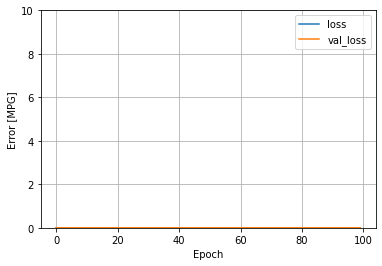

In [103]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [107]:
R2 = round(r2_score(y_true = y_test, y_pred = dnn_model.predict(X_test).flatten()),3)
RMSPE = round(rmspe(y_true = y_test, y_pred =  dnn_model.predict(X_test).flatten()),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.589, RMSPE: 0.555


In [105]:
dnn_model.evaluate(X_test, y_test)

3351/3351 [==============================] - 4s 1ms/step - loss: 0.0011  

0.0010681676212698221

In [106]:
dnn_model.predict(X_test).flatten()

array([0.00252885, 0.00298566, 0.00741746, ..., 0.0033963 , 0.0033963 ,
       0.00304204], dtype=float32)